<a href="https://colab.research.google.com/github/qas95/ML-DL-Projects/blob/main/Behavioural_Cloning_for_Selfdriving_Cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/qas95/Self-Driving-Car-Simulator-data.git

Cloning into 'Self-Driving-Car-Simulator-data'...
remote: Enumerating objects: 15770, done.
remote: Total 15770 (delta 0), reused 0 (delta 0), pack-reused 15770
Receiving objects: 100% (15770/15770), 202.85 MiB | 41.96 MiB/s, done.
Checking out files: 100% (15767/15767), done.


In [ ]:
!ls

sample_data  Self-Driving-Car-Simulator-data


In [ ]:
!ls Self-Driving-Car-Simulator-data/

driving_log.csv  IMG


In [ ]:
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.optimizers import Adam
import pandas as pd
import cv2
import random
import ntpath
pd.set_option('display.max_colwidth', -1)
import seaborn as sns
from sklearn.utils import shuffle
import sklearn
import matplotlib.image as mpimg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == '':


In [ ]:
sns.set_style('darkgrid')

In [ ]:
datadir = 'Self-Driving-Car-Simulator-data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/Users/qas/Desktop/untitled folder 2/IMG/center_2021_02_10_16_16_53_376.jpg,/Users/qas/Desktop/untitled folder 2/IMG/left_2021_02_10_16_16_53_376.jpg,/Users/qas/Desktop/untitled folder 2/IMG/right_2021_02_10_16_16_53_376.jpg,0.0,0.0,0.0,0.000080
1,/Users/qas/Desktop/untitled folder 2/IMG/center_2021_02_10_16_16_53_481.jpg,/Users/qas/Desktop/untitled folder 2/IMG/left_2021_02_10_16_16_53_481.jpg,/Users/qas/Desktop/untitled folder 2/IMG/right_2021_02_10_16_16_53_481.jpg,0.0,0.0,0.0,0.000078
2,/Users/qas/Desktop/untitled folder 2/IMG/center_2021_02_10_16_16_53_614.jpg,/Users/qas/Desktop/untitled folder 2/IMG/left_2021_02_10_16_16_53_614.jpg,/Users/qas/Desktop/untitled folder 2/IMG/right_2021_02_10_16_16_53_614.jpg,0.0,0.0,0.0,0.000078
3,/Users/qas/Desktop/untitled folder 2/IMG/center_2021_02_10_16_16_53_734.jpg,/Users/qas/Desktop/untitled folder 2/IMG/left_2021_02_10_16_16_53_734.jpg,/Users/qas/Desktop/untitled folder 2/IMG/right_2021_02_10_16_16_53_734.jpg,0.0,0.0,0.0,0.000078
4,/Users/qas/Desktop/untitled folder 2/IMG/center_2021_02_10_16_16_53_861.jpg,/Users/qas/Desktop/untitled folder 2/IMG/left_2021_02_10_16_16_53_861.jpg,/Users/qas/Desktop/untitled folder 2/IMG/right_2021_02_10_16_16_53_861.jpg,0.0,0.0,0.0,0.000078


In [ ]:
def path_lead(path):
  head, tail = ntpath.split(path)
  return tail

In [ ]:
data['center'] = data['center'].apply(path_lead)
data['left'] = data['left'].apply(path_lead)
data['right'] = data['right'].apply(path_lead)

In [ ]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_02_10_16_16_53_376.jpg,left_2021_02_10_16_16_53_376.jpg,right_2021_02_10_16_16_53_376.jpg,0.0,0.0,0.0,0.000080
1,center_2021_02_10_16_16_53_481.jpg,left_2021_02_10_16_16_53_481.jpg,right_2021_02_10_16_16_53_481.jpg,0.0,0.0,0.0,0.000078
2,center_2021_02_10_16_16_53_614.jpg,left_2021_02_10_16_16_53_614.jpg,right_2021_02_10_16_16_53_614.jpg,0.0,0.0,0.0,0.000078
3,center_2021_02_10_16_16_53_734.jpg,left_2021_02_10_16_16_53_734.jpg,right_2021_02_10_16_16_53_734.jpg,0.0,0.0,0.0,0.000078
4,center_2021_02_10_16_16_53_861.jpg,left_2021_02_10_16_16_53_861.jpg,right_2021_02_10_16_16_53_861.jpg,0.0,0.0,0.0,0.000078


In [ ]:
n_bins = 25
hist, bins = np.histogram(data['steering'], n_bins)

In [ ]:
center = (bins[:-1] + bins[1:]) * 0.5
print(center)

[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


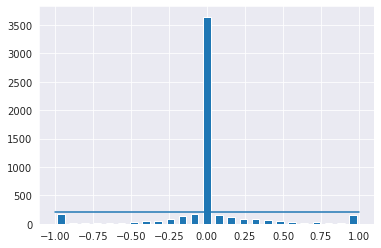

In [ ]:
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (200,200))
plt.show()

In [ ]:
print('total data:', len(data))
remove_list = []

for j in range(n_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[200:]
  remove_list.extend(list_)
print('removed list', len(remove_list))
data.drop(remove_list, inplace = True)
print('remaining data', len(data))

total data: 5255
removed list 3444
remaining data 1811


In [ ]:
n_bins = 25
hist, bins = np.histogram(data['steering'], n_bins)
center = (bins[:-1] + bins[1:]) * 0.5
print(center)

[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


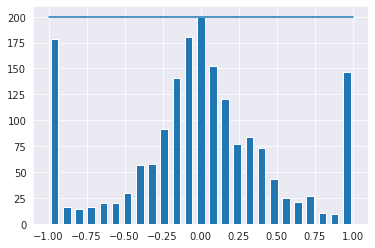

In [ ]:
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (200,200))
plt.show()

In [ ]:
def load_img_data(datadir, df):
  image_path = []
  steering = []
  for i in range(len(df)):
    indexed_data = df.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_path = np.asarray(image_path)
  steering = np.asarray(steering)

  return image_path, steering

In [ ]:
image_path, steering = load_img_data(datadir+ '/IMG', data)


In [ ]:
len(image_path)

1811

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_path, steering, test_size = 0.2, random_state = 123, shuffle = True)

In [ ]:
print('Training data : {} \nValidation data : {}'.format(X_train.shape[0], X_val.shape[0]))

Training data : 1448 
Validation data : 363


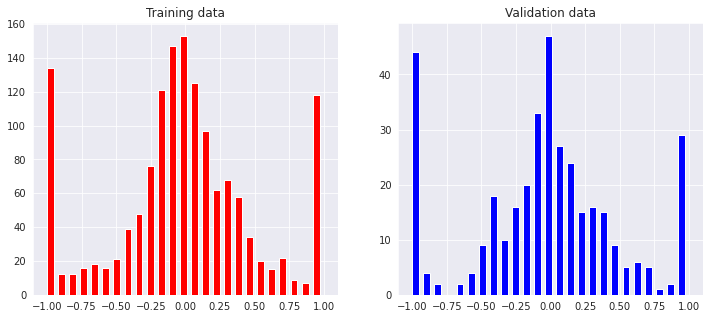

In [ ]:
fig, axes = plt.subplots(1,2, figsize =(12,5))
axes[0].hist(y_train, bins = n_bins, width = 0.05, color = 'red')
axes[0].set_title('Training data')
axes[1].hist(y_val, bins = n_bins, width = 0.05, color = 'blue')
axes[1].set_title('Validation data')

plt.show()

Preprocessing the images to select the right features

In [ ]:
def preprocess_img(img):
  img = mpimg.imread(img)
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3),0)
  img = cv2.resize(img, (200,66))
  return img

Text(0.5, 1.0, 'Preprocessed Image')

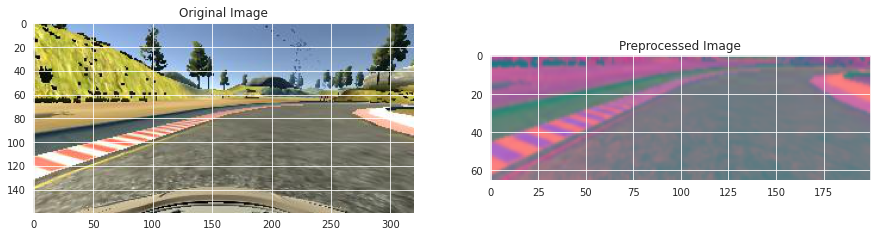

In [ ]:
image = mpimg.imread(X_train[1])
fig.tight_layout()

fig, axes = plt.subplots(1,2, figsize = (15,10))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocess_img(X_train[1]))
axes[1].set_title('Preprocessed Image')

In [ ]:
X_train = np.array(list(map(preprocess_img, X_train)))
X_val = np.array(list(map(preprocess_img, X_val)))

(1448, 66, 200, 3)


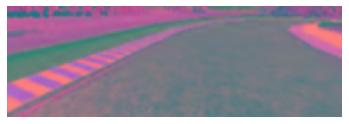

In [ ]:
plt.imshow(X_train[1])
plt.axis('off')
print(X_train.shape)

Definig the NVIDIA Model for behavioural cloning

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5,5), strides = (2,2), input_shape = (66,200,3), activation='elu'))
  model.add(Conv2D(36, (5,5), strides = (2,2), activation='elu'))
  model.add(Conv2D(48, (5,5), strides = (2,2), activation='elu'))
  model.add(Conv2D(64, (3,3), activation='elu'))
  model.add(Conv2D(64, (3,3), activation='elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.compile(loss = 'mse', optimizer = Adam(0.0001))
  return model

In [ ]:
model = nvidia_model()

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_24 (Dropout)         (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1152)             

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=30, verbose= 1, shuffle = 1, batch_size=1)

Epoch 1/30
1448/1448 [==============================] - 5s 3ms/step - loss: 37.1660 - val_loss: 0.6725
Epoch 2/30
1448/1448 [==============================] - 4s 3ms/step - loss: 3.0211 - val_loss: 0.5831
Epoch 3/30
1448/1448 [==============================] - 4s 3ms/step - loss: 2.0615 - val_loss: 0.5688
Epoch 4/30
1448/1448 [==============================] - 4s 3ms/step - loss: 2.1621 - val_loss: 0.6670
Epoch 5/30
1448/1448 [==============================] - 4s 3ms/step - loss: 1.8159 - val_loss: 0.3865
Epoch 6/30
1448/1448 [==============================] - 4s 3ms/step - loss: 1.5677 - val_loss: 0.3855
Epoch 7/30
1448/1448 [==============================] - 4s 3ms/step - loss: 1.3443 - val_loss: 0.2890
Epoch 8/30
1448/1448 [==============================] - 4s 3ms/step - loss: 1.0799 - val_loss: 0.3141
Epoch 9/30
1448/1448 [==============================] - 4s 3ms/step - loss: 1.1155 - val_loss: 0.3171
Epoch 10/30
1448/1448 [==============================] - 4s 3ms/step - loss: 0.80

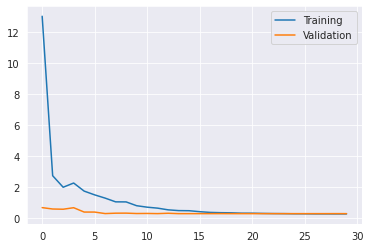

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.show()

In [ ]:
model.save('model.h5')

In [ ]:
from google.colab import files

In [ ]:
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>